In [1]:
import pandas as pd
import numpy as np
import datetime

dfs = []
# Data is split into 79 files
for i in range(2,6):
    df = pd.read_csv(f"data/2022_place_canvas_history-00000000000{i}.csv.gzip", compression="gzip")
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,timestamp,user_id,pixel_color,coordinate
0,2022-04-03 23:26:51.728 UTC,+BcYGiFJxBvAzOnV3REE5QMEPNsiyap/FvF/rC8PyyEwZo...,#00CCC0,"1893,1819"
1,2022-04-03 23:26:52.014 UTC,4GJMdiRnQJ1uPZopovZ2YegssXlFDstdX09p+Pi2DWMX0N...,#00CCC0,"686,216"
2,2022-04-03 23:26:52.826 UTC,/LZrfPhkMz0GzrB4xocPyK2RBynr4IARDFcYuhSFGX6dA3...,#6A5CFF,"789,1119"
3,2022-04-03 23:26:56.72 UTC,W45ecAW59SqdwGybFg8dOAs3nQvwFZtXsaT2lWKs0cCtLD...,#6A5CFF,"778,1194"
4,2022-04-03 23:26:58.601 UTC,ZaNTP/q2q4sLhnXwF+WiAUoC2JQztcRSA8SnMM+/CdoG+C...,#00CCC0,"1028,1235"


Pandas have a built-in data parser but in my experience, it is super slow (in this example it was about 7 times slower).

In [2]:
def parse_date(date):
    try:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S')

df['timestamp'] = df['timestamp'].apply(lambda x: parse_date(x))

Those cells are split to easily see the **runtime** of the **data parser**.

In [3]:
df['user_id'] = df['user_id'].astype('string')
df['pixel_color'] = df['pixel_color'].astype('string')

def parse_cord(cord):
    try:
        return float(cord.replace(",", "."))
    except ValueError:
        # Mods sometimes used the rectangle tool to censor NSFW, in those cases cords look like this (x1,y1,x2,y2).
        # With the code below we can get a tuple with opposite rectangle corners, but I didn't need that data.
        ###
        # cords = cord.split('.')
        # return (float(cord[0]+'.'+cord[1]), float(cord[2]+'.'+cord[3]))
        ###
        return np.NaN


df["coordinate"] = df["coordinate"].apply(lambda x: parse_cord(x))

df.dropna(how="any")
df.dtypes

timestamp      datetime64[ns]
user_id                string
pixel_color            string
coordinate            float64
dtype: object

### Prepare matplotlib
Each analysis will be split into three parts:
1. Description
2. Data editing
3. Ploting

In [37]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
figsize = (20, 10)

#### Pixels per color
We are getting **number of pixels** placed depending on **color** of the **pixel**.

In [38]:
colors = df["pixel_color"].value_counts().rename_axis('pixel_color').to_frame('counts').reset_index()
colors.head()

,pixel_color,counts
0,#000000,1729463
1,#FFFFFF,1434290
2,#2450A4,526139
3,#FF4500,474166
4,#BE0039,443756


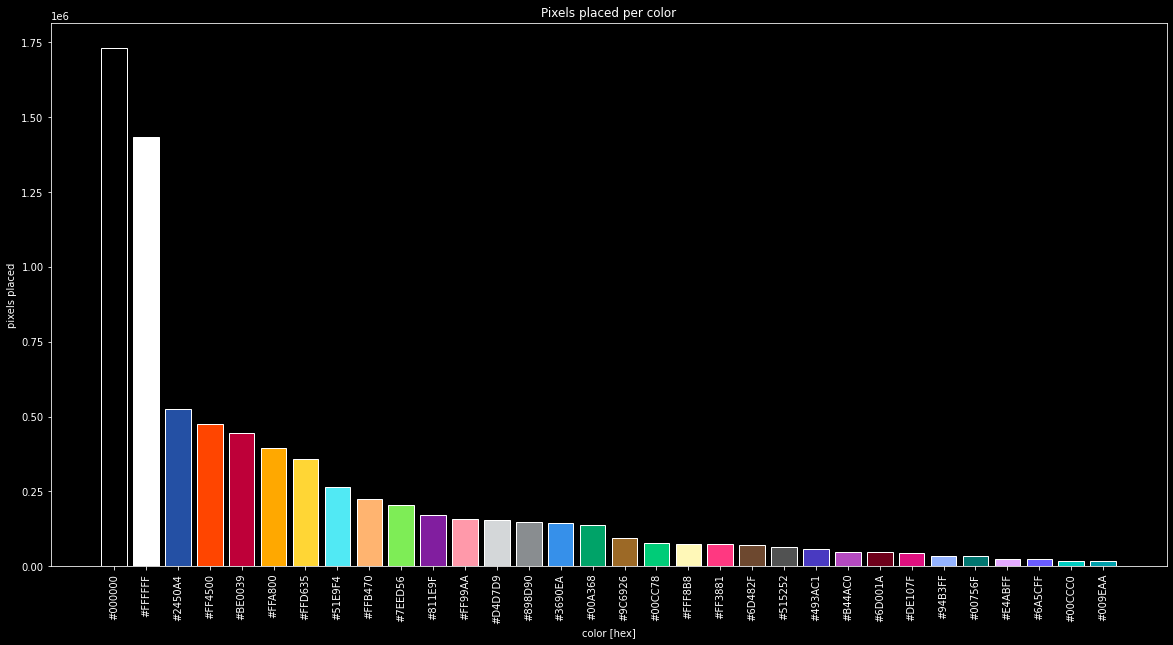

In [39]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(colors["pixel_color"], colors["counts"], color=colors["pixel_color"], edgecolor="#FFFFFF")
ax.set_title('Pixels placed per color')
ax.set_xlabel('color [hex]')
ax.set_ylabel('pixels placed')
plt.xticks(rotation=90)
fig.savefig('./plots/color_counts.pdf')

#### Max pixels placed per user based on color
Same thing as above but we are getting **maximum** number of **pixels** placed by **one user** based on **color**.

In [40]:
colors = df.iloc[:, 1:3]
colors['count'] = 1
colors= pd.pivot_table(colors, values='count', index='user_id', columns='pixel_color', aggfunc='count')

color_user = pd.DataFrame(columns=["pixel_color", "user_max"])
for name, column in colors.items():
    color_user = color_user.append({"pixel_color": name, "user_max": column.max()}, ignore_index = True)
color_user.sort_values(by='user_max', ascending = False, inplace=True)


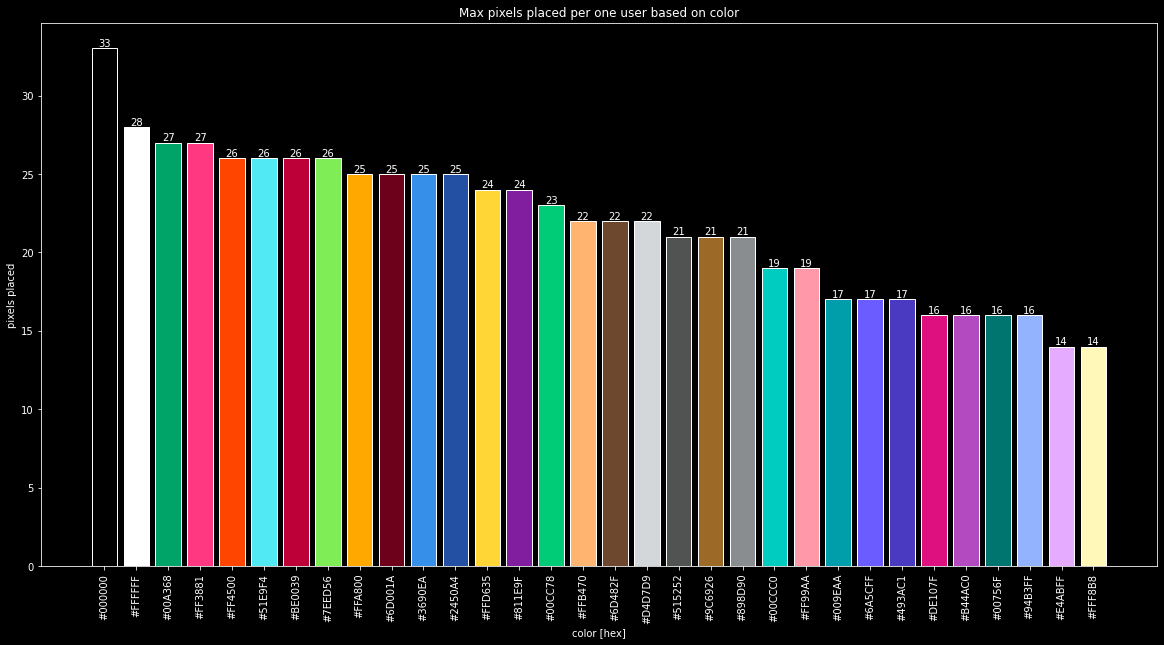

In [41]:
fig, ax = plt.subplots(figsize=figsize)
bars = ax.bar(color_user["pixel_color"], color_user["user_max"], color=color_user["pixel_color"], edgecolor="#FFFFFF")
ax.bar_label(bars)
ax.set_title('Max pixels placed per one user based on color')
ax.set_xlabel('color [hex]')
ax.set_ylabel('pixels placed')
plt.xticks(rotation=90)
fig.savefig('./plots/color_user_counts.pdf')

In [48]:
pix_usr = df["user_id"].value_counts().to_frame('pixels').reset_index()
# We really only need the counts now
pix_usr = pix_usr.drop(["index"].index, 1)
# We will use pix_usr later on
pix_usr_count = pix_usr["pixels"].value_counts().rename_axis('pixels').to_frame('howmany').reset_index()
pix_usr_count.head()

C:\Users\Dawid\AppData\Local\Temp\ipykernel_24512\3523259650.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pix_usr = pix_usr.drop(pix_usr.index, 1)


KeyError: '[0 1 2 ... 2351527 2351528 2351529] not found in axis'

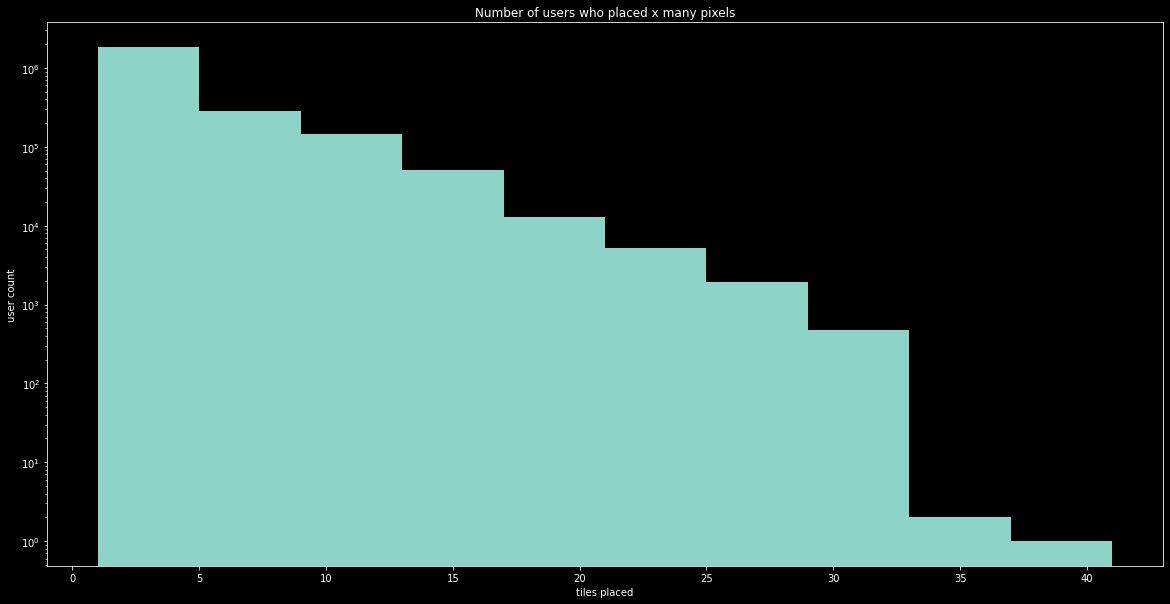

In [43]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_yscale('log')
ax.set_ylabel('user count')
ax.set_xlabel('tiles placed')
ax.set_title('Number of users who placed x many pixels')
ax.hist(pix_usr['pixels'])
fig.savefig("./plots/tiles_per_user.pdf")

In [45]:
pix_usr = pix_usr[:10]
pix_usr.index += 1

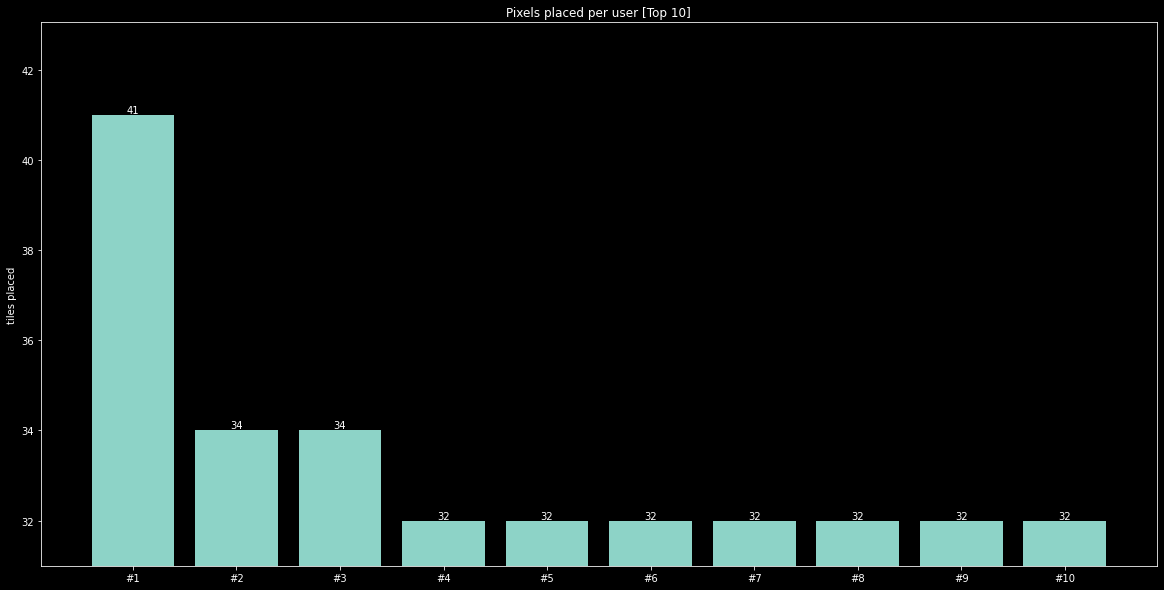

In [46]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel('tiles placed')
ax.set_title('Pixels placed per user [Top 10]')
bars = ax.bar(['#'+str(i) for i in pix_usr.index], pix_usr['pixels'])
ax.bar_label(bars)
ax.set_ylim(ymin=min(pix_usr['pixels']-1))
fig.savefig('./plots/top10_tiles_per_user.pdf')